In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
from numpy import genfromtxt
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from keras import layers
from keras.utils import np_utils
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from keras.datasets import mnist
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
training_data = genfromtxt(os.path.join(dirname, filenames[1]), delimiter=',', skip_header = 1)

X_test = genfromtxt(os.path.join(dirname, filenames[2]), delimiter=',', skip_header = 1)
X_test = X_test.reshape(X_test.shape[0], 28 ,28, 1)
X_test = tf.keras.utils.normalize(X_test, axis = 1)

Y = training_data[:,0]
Y = np.concatenate((Y, y_train, y_test))
Y = np_utils.to_categorical(Y)

X = training_data[:,1:]
X = np.reshape(X, (-1, 28, 28))
X = np.concatenate((X, x_train, x_test))
X = X.reshape(X.shape[0], 28 ,28, 1)
X = tf.keras.utils.normalize(X, axis = 1)

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2, random_state = 0)

11493376/11490434 [==============================] - 0s 0us/step


In [3]:
early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
)

model = tf.keras.models.Sequential([
    
    # convolution block
    layers.Conv2D(128, (3,3), input_shape = (28,28,1), activation = 'relu'),
    layers.Conv2D(128, (3,3), activation = 'relu'),
    layers.MaxPooling2D(pool_size = (2,2)),
    layers.Conv2D(128, (5,5), activation = 'relu'),
    layers.Conv2D(128, (5,5), activation = 'relu'),
    layers.MaxPooling2D(pool_size = (2,2)),
    
    # classifier head
    layers.Flatten(),
    layers.BatchNormalization(),
    layers.Dense(512, activation = tf.nn.relu),
    layers.Dropout(0.2),
    layers.BatchNormalization(),
    layers.Dense(512, activation = tf.nn.relu),
    layers.Dropout(0.2),
    layers.BatchNormalization(),
    layers.Dense(512, activation = tf.nn.relu),
    layers.Dropout(0.2),
    layers.BatchNormalization(),
    layers.Dense(512, activation = tf.nn.relu),
    layers.Dropout(0.2),
    layers.Dense(10, activation = tf.nn.softmax)
])

model.compile(optimizer = 'adam',
             loss = 'categorical_crossentropy',
             metrics = ['categorical_accuracy'])

history = model.fit(
    X_train, 
    Y_train,
    validation_data = (X_val, Y_val),
    epochs = 64,
    callbacks = [early_stopping]
    )

Epoch 1/64
2800/2800 [==============================] - 24s 8ms/step - loss: 0.1877 - categorical_accuracy: 0.9462 - val_loss: 0.0785 - val_categorical_accuracy: 0.9800
Epoch 2/64
2800/2800 [==============================] - 23s 8ms/step - loss: 0.0834 - categorical_accuracy: 0.9780 - val_loss: 0.0636 - val_categorical_accuracy: 0.9833
Epoch 3/64
2800/2800 [==============================] - 22s 8ms/step - loss: 0.0641 - categorical_accuracy: 0.9836 - val_loss: 0.0256 - val_categorical_accuracy: 0.9933
Epoch 4/64
2800/2800 [==============================] - 23s 8ms/step - loss: 0.0518 - categorical_accuracy: 0.9869 - val_loss: 0.0268 - val_categorical_accuracy: 0.9934
Epoch 5/64
2800/2800 [==============================] - 22s 8ms/step - loss: 0.0408 - categorical_accuracy: 0.9895 - val_loss: 0.0236 - val_categorical_accuracy: 0.9937
Epoch 6/64
2800/2800 [==============================] - 23s 8ms/step - loss: 0.0343 - categorical_accuracy: 0.9911 - val_loss: 0.0326 - val_categorical_acc

700/700 [==============================] - 2s 3ms/step - loss: 0.0145 - categorical_accuracy: 0.9972
test loss, test acc: [0.014518799260258675, 0.9972321391105652]


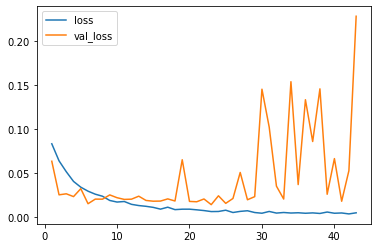

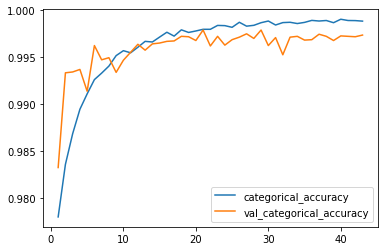

In [4]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[1:, ['loss', 'val_loss']].plot()
history_frame.loc[1:, ['categorical_accuracy', 'val_categorical_accuracy']].plot()

scores = model.evaluate(X_val, Y_val)
print("test loss, test acc:", scores)

In [5]:
predictions = model.predict(X_test)
Y_pred = predictions.argmax(axis = 1)
ImageID = np.arange(len(Y_pred))+1
submit = pd.DataFrame([ImageID,Y_pred]).T
submit.rename(columns = {0:'ImageId', 1:'Label'})

submit.to_csv('submission.csv', header =  ['ImageId', 'Label' ], index = None) 